# Workflow B example - visualise synchrony over time

This is an example of what we describe as 'workflow B' in our pre-print https://psyarxiv.com/abquk/, where the analyst wants to visualise the development of synchrony over time. 

This notebook was originally created to assist students who were getting familiar with multiSyncPy, but may be helpful to others also. 

In [111]:
import numpy as np
import multiSyncPy as msp
from multiSyncPy import synchrony_metrics as sm
from multiSyncPy import data_generation as dg
from matplotlib import pyplot as plt
import scipy

## Generate some data to use as an example

This code generates some data and saves it as a file, so that we can then provide an example of reading some data from a file and visualising the synchrony over time. The format of the file is inspired by outputs from software to compute motion energy analysis (MEA) on videos, but we use synthetic data here because the original files cannot be shared publicly. The format of the file is intended to match to a situation where there are 8 participants and they are being recorded at 25 frames per second. 

In [35]:
example_data = dg.kuramoto_data(
    phases=np.array([0.0, 0.25*np.pi, 0.5*np.pi, 0.75*np.pi, 1.0*np.pi, 1.25*np.pi, 1.50*np.pi, 1.75*np.pi]),
    omegas=np.array([1, 1.5, 2, 3, 4, 5, 6, 7]),
    K=1.0,
    alpha=0.5,
    d_t=1/25,
    length=2843
)

In [36]:
example_data.shape

(8, 2843)

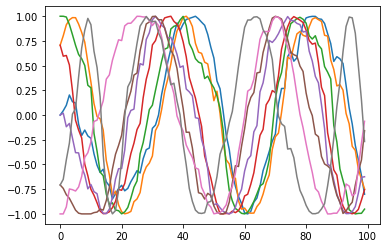

In [37]:
plt.plot(example_data.T[:100])

#### Save to an example file

In [52]:
with open("example_data.txt", "w") as f:
    
    out_list = []
    
    for row in example_data.T:
        
        out_list.append("{:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} 0".format(*row.tolist()))
        
    f.write("\n".join(out_list))

## Load file to use in analysis

Here, the data from our example txt file is loaded into the correct format. Of course, if the file had a different format then a different loading procedure would have been needed. 

In [73]:
with open("example_data.txt", "r") as f:
    
    loaded_data = f.readlines()

In [83]:
# Break each line down into its component measurements, and exclude the end-of-line '0' value
data = [x.strip().split()[:-1] for x in loaded_data]

# Convert to a numpy array with the variables as the first axis and the time steps as the second axis
data = np.array(data).T

# Convert strings to floats
data = data.astype(float)

In [84]:
data.shape

(8, 2843)

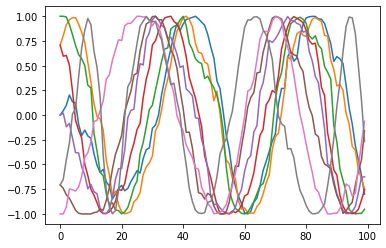

In [87]:
plt.plot(data.T[:100])

## Plot synchronisation over time

Now, the ability to visualise synchronisation over time is showcased. Some functions, namely `coherence` and `symbolic_entropy` can be applied directly with `apply_windowed`. For other functions, i.e. `determinism` and `rho`, we create functions that provide the necessary parameter settings and that reduce the number of return values (so that a single number is returned for each window position). 

#### Determinism

In [97]:
# Function to apply to windows
# This calculates the % determinism
# Note that the radius is set here while creating the function
determinism_func = lambda x: sm.rqa_metrics(sm.recurrence_matrix(x, radius=1.5))[1]

# Just to check it works
determinism_func(data)

0.052467101314066206

In [103]:
# Calculate determinism over time, with a window size of 75 = 3 seconds and step of 25 = 1 second

determinism_over_time = sm.apply_windowed(data, determinism_func, window_length=75, step=25)

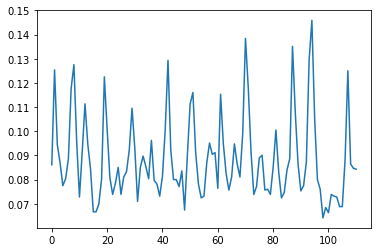

In [104]:
plt.plot(determinism_over_time)

#### Coherence

In [106]:
# Calculate determinism over time, with a window size of 75 = 3 seconds and step of 25 = 1 second
coherence_over_time = sm.apply_windowed(data, sm.coherence_team, window_length=75, step=25)

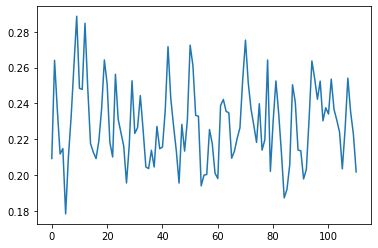

In [107]:
plt.plot(coherence_over_time)

#### Symbolic entropy

In [108]:
# Calculate determinism over time, with a window size of 75 = 3 seconds and step of 25 = 1 second
entropy_over_time = sm.apply_windowed(data, sm.symbolic_entropy, window_length=75, step=25)

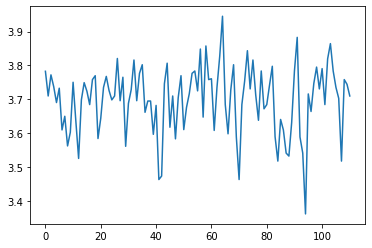

In [109]:
plt.plot(entropy_over_time)

#### Rho

In [120]:
# First we need to convert to the phase time series
# The simplest way is to use the Hilbert transform, but wavelet analysis may be preferable in practice
data_phases = np.angle(scipy.signal.hilbert(data))

# Function to return only the single number value of rho (and not the sequence of values that sm.rho also returns)
rho_func = lambda x: sm.rho(x)[1]

# Calculate determinism over time, with a window size of 75 = 3 seconds and step of 25 = 1 second
# Note we use data_phases
rho_over_time = sm.apply_windowed(data_phases, rho_func, window_length=75, step=25)

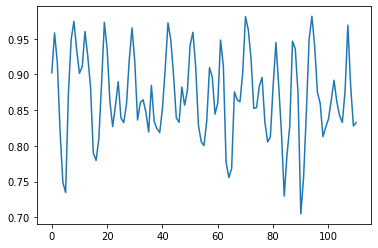

In [122]:
plt.plot(rho_over_time)